In [1]:
import os
import cv2
import tqdm
import time
import string
import pathlib
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix, roc_auc_score, roc_curve

from typing import List
from matplotlib import pyplot as plt

from predict import Prediction
from utils.rgb import mask2rgb
from utils.prediction.evaluations import visualize, preload_image_data

# Logging
from utils.logging import logging

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

c:\Posao\firebot-segmentation\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Variables

In [2]:
metrics_models = [
    { 
        'model_name': 'U-Net 256x256',
        'model_path': r'checkpoints/avid-forest-323/best-checkpoint.pth.tar',
        'patch_size': 256,
    },
    { 
        'model_name': 'U-Net 512x512',
        'model_path': r'checkpoints/helpful-sky-334/best-checkpoint.pth.tar',
        'patch_size': 512,
    },
   { 
        'model_name': 'U-Net 640x640',
        'model_path': r'checkpoints/graceful-snowball-337/best-checkpoint.pth.tar',
        'patch_size': 640,
    }, 
    { 
        'model_name': 'U-Net 768x768',
        'model_path': r'checkpoints/silvery-serenity-371/best-checkpoint.pth.tar',
        'patch_size': 768,
    },
    { 
        'model_name': 'U-Net 800x800',
        'model_path': r'checkpoints/kind-totem-369/best-checkpoint.pth.tar',
        'patch_size': 800,
    },
    { 
        'model_name': 'U-Net 864x864',
        'model_path': r'checkpoints/swept-field-374/best-checkpoint.pth.tar',
        'patch_size': 864,
    },
    { 
        'model_name': 'U-Net 960x960',
        'model_path': r'checkpoints/giddy-leaf-375/best-checkpoint.pth.tar',
        'patch_size': 960,
    },
    { 
        'model_name': 'U-Net 1088x1088',
        'model_path': r'checkpoints/masked-orb-376/best-checkpoint.pth.tar',
        'patch_size': 1088,
    },
]
metrics_model_index = 0

metrics_output = pathlib.Path('metrics_output')
model_metrics_output = pathlib.Path(metrics_output, metrics_models[metrics_model_index]['model_name'])

# Create directory if it doesn't exists
if not os.path.isdir(model_metrics_output):
    os.makedirs(model_metrics_output)

## Util Functions

In [3]:
log.info('[DATA]: Started preloading test images and labels!')
test_imgs = preload_image_data(r'data', r'imgs', False, metrics_models[metrics_model_index]['patch_size'])
test_labels = preload_image_data(r'data', r'imgs', True, metrics_models[metrics_model_index]['patch_size'])

[DATA]: Started preloading test images and labels!


## Model prediction

In [4]:
model_params = {
    'model_name': metrics_models[metrics_model_index]['model_path'],
    'patch_width': metrics_models[metrics_model_index]['patch_size'],
    'patch_height': metrics_models[metrics_model_index]['patch_size'],
    'n_channels': 3,
    'n_classes': 3
}
model = Prediction(model_params)
model.initialize()

log.info('[PREDICTION]: Model loaded!')
log.info(f'[PREDICTION]: Starting prediction on {len(test_imgs)} image(s).')

predicted_labels = []
img_process_time_list = []
m_ious = []

batch_start_time = time.time()
pbar = tqdm.tqdm(enumerate(test_imgs), total=len(test_imgs))
for i, img in pbar:
    img_start_time = time.time()
    mask_predict = model.predict_image(img)
    img_process_time = time.time() - img_start_time

    predicted_labels.append(mask_predict)
    img_process_time_list.append(img_process_time * 1000)

pbar.close()
batch_process_time = time.time() - batch_start_time


[PREDICTION]: Loading model checkpoints/avid-forest-323/best-checkpoint.pth.tar
[PREDICTION]: Model loaded!
[PREDICTION]: Starting prediction on 683 image(s).


100%|██████████| 683/683 [00:07<00:00, 91.89it/s] 


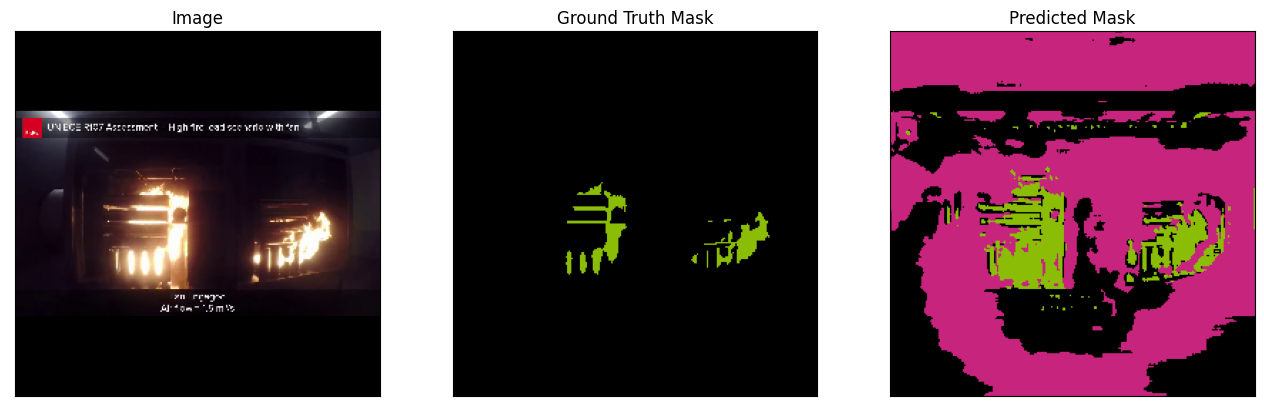

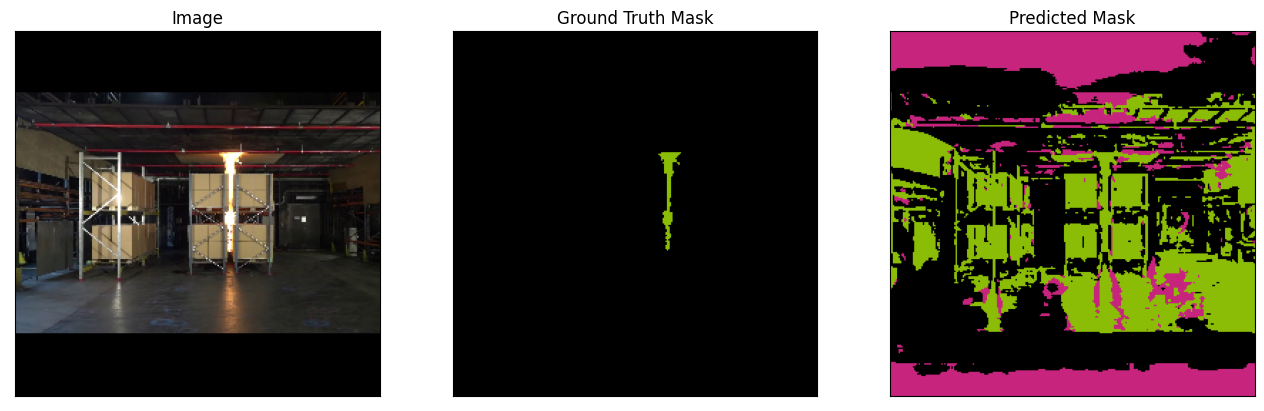

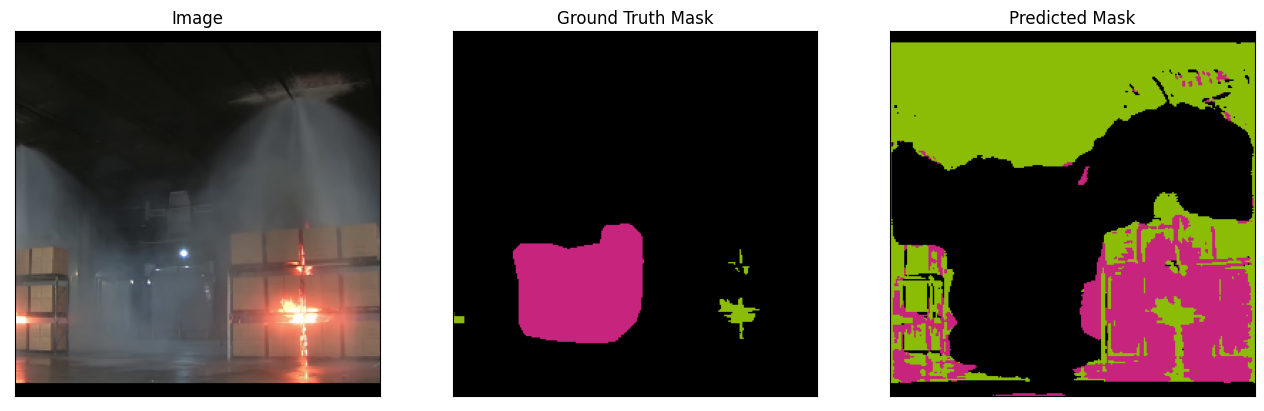

In [5]:
visualize(
    save_path=model_metrics_output,
    prefix='1',
    image=test_imgs[8], 
    ground_truth_mask=mask2rgb(test_labels[8]), 
    predicted_mask=mask2rgb(predicted_labels[8]),
)

visualize(
    save_path=model_metrics_output,
    prefix='2',
    image=test_imgs[16], 
    ground_truth_mask=mask2rgb(test_labels[16]), 
    predicted_mask=mask2rgb(predicted_labels[16]),
)

visualize(
    save_path=model_metrics_output,
    prefix='3',
    image=test_imgs[32], 
    ground_truth_mask=mask2rgb(test_labels[32]), 
    predicted_mask=mask2rgb(predicted_labels[32]),
)

### Getting Metrics

In [6]:
def get_precision_recall_auc(ground_truth, predicted):
    precision, recall, _ = precision_recall_curve(ground_truth, predicted)
    return precision, recall, auc(precision, recall)

def get_classification_report(ground_truth, predicted, postfix):
    report = classification_report(ground_truth, predicted, output_dict=True, digits = 6)
    conf = confusion_matrix(ground_truth, predicted)

    # Configure report data
    report['1.0'].pop('support')
    report['1.0'][f'Precision {postfix}'] = report['1.0']['precision']
    report['1.0'][f'Recall {postfix}'] = report['1.0']['recall']
    report['1.0'][f'F1-Score {postfix}'] = report['1.0']['f1-score']
    report['1.0'][f'Accuracy {postfix}'] = report['accuracy']
    report['1.0'][f'TP {postfix}'] = conf[1][1]
    report['1.0'][f'TN {postfix}'] = conf[0][0]
    report['1.0'][f'FP {postfix}'] = conf[0][1]
    report['1.0'][f'FN {postfix}'] = conf[1][0]

    # Calculate ROC and AUC score & ROC curve
    auc_s = roc_auc_score(ground_truth, predicted)
    fpr, tpr, _ = roc_curve(ground_truth, predicted)

    # Return classification report only for class laber (not background)
    return report['1.0'], auc_s, fpr, tpr

[METRICS]: Started converting RGB masks to binary masks!


100%|██████████| 683/683 [00:00<00:00, 1092.80it/s]


[METRICS]: Started converting RGB masks to binary masks!
[METRICS]: Started calculating Precision-Recall curve!
[METRICS]: Started plotting Precision-Recall curve!
Precision: 0.37693 | Recall: 0.63192 | AUC: 0.47592 | Max. Processing Time: 2095.00ms | Avg. Processing Time: 10.83ms | Min. Processing Time: 7.00ms | Whole Processing Time: 7435s


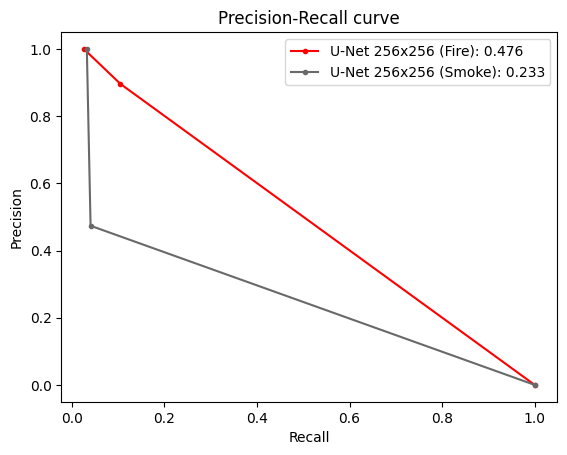

In [7]:
# Vars
plot_colors = ['red', 'dimgray']
gt_list_fire = []
pred_list_fire = []

gt_list_smoke = []
pred_list_smoke = []


log.info('[METRICS]: Started converting RGB masks to binary masks!')
pbar = tqdm.tqdm(enumerate(test_labels), total=len(test_labels))
for i, label in pbar:
    # Fire
    ground_truth_fire = cv2.inRange(label, 1, 1)
    prediction_fire = cv2.inRange(predicted_labels[i], 1, 1)

    gt_mapped_fire = ground_truth_fire.flatten().astype('float') / 255
    pred_mapped_fire = prediction_fire.flatten().astype('float') / 255

    gt_list_fire.append(gt_mapped_fire)
    pred_list_fire.append(pred_mapped_fire)

    # Smoke
    ground_truth_smoke = cv2.inRange(label, 2, 2)
    prediction_smoke = cv2.inRange(predicted_labels[i], 2, 2)

    gt_mapped_smoke = ground_truth_smoke.flatten().astype('float') / 255
    pred_mapped_smoke = prediction_smoke.flatten().astype('float') / 255

    gt_list_smoke.append(gt_mapped_smoke)
    pred_list_smoke.append(pred_mapped_smoke)
pbar.close()

# Global Vars
gt_flatten_fire, pred_flatten_fire = np.asarray(gt_list_fire).flatten(), np.asarray(pred_list_fire).flatten()
gt_flatten_smoke, pred_flatten_smoke = np.asarray(gt_list_smoke).flatten(), np.asarray(pred_list_smoke).flatten()

# Remove Unused Data From Memory
log.info('[METRICS]: Started converting RGB masks to binary masks!')
del test_imgs
del test_labels

# Calculate Metrics
log.info('[METRICS]: Started calculating Precision-Recall curve!')
precision_fire, recall_fire, auc_fire = get_precision_recall_auc(gt_flatten_fire, pred_flatten_fire)
precision_smoke, recall_smoke, auc_smoke = get_precision_recall_auc(gt_flatten_smoke, pred_flatten_smoke)

# Plot Precision-Recall curve
log.info('[METRICS]: Started plotting Precision-Recall curve!')
plt.plot(precision_fire, recall_fire, marker='.', color=plot_colors[0], label=f'{metrics_models[metrics_model_index]["model_name"]} (Fire): {round(auc_fire, 3)}')
plt.plot(precision_smoke, recall_smoke, marker='.', color=plot_colors[1], label=f'{metrics_models[metrics_model_index]["model_name"]} (Smoke): {round(auc_smoke, 3)}')

plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig(f"{str(model_metrics_output.resolve())}/precision_recall_curve.svg", format='svg', dpi=300)
# plt.show()

# String log evaluation metrics
log.info(
f'Precision: {np.mean(precision_fire):.5f} | \
Recall: {np.mean(recall_fire):.5f} | \
AUC: {np.mean(auc_fire):.5f} | \
Max. Processing Time: {np.amax(img_process_time_list):.2f}ms | \
Avg. Processing Time: {np.mean(img_process_time_list):.2f}ms | \
Min. Processing Time: {np.amin(img_process_time_list):.2f}ms | \
Whole Processing Time: {(batch_process_time * 1000):.0f}s'
)

### Classification Report & ROC curve

[REPORT]: Started calculating classification report for fire!
[REPORT]: Started calculating classification report for smoke!
[METRICS]: Started plotting ROC curve!


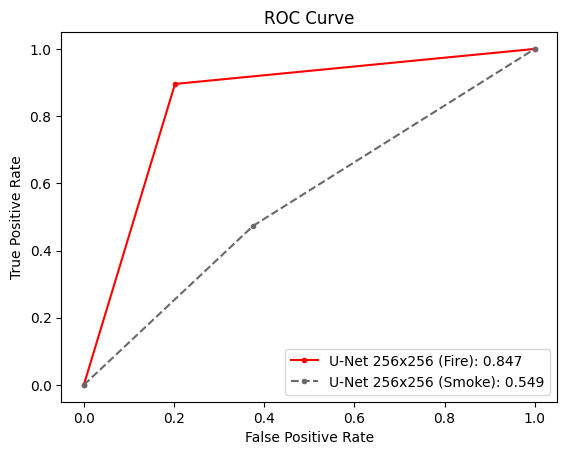

In [8]:
log.info('[REPORT]: Started calculating classification report for fire!')
report_data_fire, auc_fire, fpr_fire, tpr_fire = get_classification_report(gt_flatten_fire, pred_flatten_fire, '(fire)')

log.info('[REPORT]: Started calculating classification report for smoke!')
report_data_smoke, auc_smoke, fpr_smoke, tpr_smoke = get_classification_report(gt_flatten_smoke, pred_flatten_smoke, '(smoke)')

log.info('[METRICS]: Started plotting ROC curve!')
plt.plot(fpr_fire, tpr_fire, marker='.', color=plot_colors[0], label=f'{metrics_models[metrics_model_index]["model_name"]} (Fire): {round(auc_fire, 3)}')
plt.plot(fpr_smoke, tpr_smoke, marker='.', color=plot_colors[1], linestyle='--', label=f'{metrics_models[metrics_model_index]["model_name"]} (Smoke): {round(auc_smoke, 3)}')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.savefig(f"{str(model_metrics_output.resolve())}/roc_curve.svg", format='svg', dpi=300)
# plt.show()

### Saving report data to Excel

In [9]:
import pandas as pd

report = {}
report_data_timings = { 'Min. Processing Time': f'{np.amin(img_process_time_list):.2f}ms', 'Max. Processing Time': f'{np.amax(img_process_time_list):.2f}ms', 'Avg. Processing Time': f'{np.mean(img_process_time_list):.2f}ms' }
report[metrics_models[metrics_model_index]['model_name']] = report_data_fire | report_data_smoke | report_data_timings

df = pd.DataFrame.from_dict(data=report, orient='index', columns=['Precision (fire)', 'Recall (fire)', 'F1-Score (fire)', 'Accuracy (fire)', 'TP (fire)', 'TN (fire)', 'FP (fire)', 'FN (fire)', 'Precision (smoke)', 'Recall (smoke)', 'F1-Score (smoke)', 'Accuracy (smoke)', 'TP (smoke)', 'TN (smoke)', 'FP (smoke)', 'FN (smoke)', 'Min. Processing Time', 'Max. Processing Time', 'Avg. Processing Time'])
df.reset_index(inplace=True)
df = df.rename(columns = { 'index': 'Model Name' })

if not os.path.isfile(f'{str(metrics_output.resolve())}/metrics_output.xlsx'):
    with pd.ExcelWriter(f'{str(metrics_output.resolve())}/metrics_output.xlsx', engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name="PredictedResults", index = False)
else:
    with pd.ExcelWriter(f'{str(metrics_output.resolve())}/metrics_output.xlsx', engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
        df.to_excel(writer, sheet_name="PredictedResults", index = False)